In [1]:
# Make necessary imports
import json
from gluonts.dataset.common import ListDataset
import os
import datetime

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import json
import os
import datetime
import torch

from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import MultivariateEvaluator
from gluonts.dataset.common import ListDataset

from pts.model.time_grad import TimeGradEstimator
from pts import Trainer

/Users/edvard/Documents/Imperial College/Year 4/Final Year Project/Final-Year-Project/timegrad/.venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Create training and test datasets
dataset_train = ListDataset(
    [
        {
            "target": np.array([np.random.choice([-1, 1], size=1000) for _ in range(2)]),
            "start": datetime.datetime(2000,1,1),
        }
    ],
    freq="D",
    one_dim_target=False
)

# Create training and test datasets
dataset_test = ListDataset(
    [
        {
            "target": np.array([np.random.choice([-1, 1], size=1000) for _ in range(2)]),
            "start": datetime.datetime(2010,1,1),
        }
    ],
    freq="D",
    one_dim_target=False
)

In [5]:
# Train timegrad on training dataset
estimator = TimeGradEstimator(
    target_dim=2,
    prediction_length=1,
    cell_type='GRU',
    input_size=10,
    freq="1D",
    loss_type='l2',
    scaling=False,
    diff_steps=100,
    beta_end=0.1,
    beta_schedule="linear",
    trainer=Trainer(device=device,
                    epochs=20,
                    learning_rate=1e-3,
                    num_batches_per_epoch=100,
                    batch_size=64,)
)

In [6]:
predictor = estimator.train(dataset_train, num_workers=4)

  0%|          | 0/99 [00:00<?, ?it/s]/Users/edvard/Documents/Imperial College/Year 4/Final Year Project/Final-Year-Project/timegrad/.venv/lib/python3.8/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/Users/edvard/Documents/Imperial College/Year 4/Final Year Project/Final-Year-Project/timegrad/.venv/lib/python3.8/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/Users/edvard/Documents/Imperial College/Year 4/Final Year Project/Final-Year-Project/timegrad/.venv/lib/python3.8/site-packages/gluonts/dataset/common.py:329: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  timestamp.floor(timestamp.freq), timestamp.freq
/Users/edvard/Documents/Imperial College/Year 4/Final Year Projec

In [7]:
# Create training and test datasets
dataset_test = ListDataset(
    [
        {
            "target": np.array([np.random.choice([-1, 1], size=1) for _ in range(2)]),
            "start": datetime.datetime(2010,1,1) + datetime.timedelta(days=i),
        }
    for i in range(1)],
    freq="D",
    one_dim_target=False
)

In [8]:
forecast_it, ts_it = make_evaluation_predictions(dataset=dataset_test,
                                                 predictor=predictor,
                                                 num_samples=100)

In [9]:
forecasts = list(forecast_it)
targets = list(ts_it)

In [ ]:
evaluator = MultivariateEvaluator(quantiles=(np.arange(20)/20.0)[1:], 
                                  target_agg_funcs={'sum': np.sum})

In [ ]:
agg_metric, item_metrics = evaluator(targets, forecasts, num_series=len(dataset_train))

In [ ]:
print("CRPS:", agg_metric["mean_wQuantileLoss"])
print("ND:", agg_metric["ND"])
print("NRMSE:", agg_metric["NRMSE"])
print("")
print("CRPS-Sum:", agg_metric["m_sum_mean_wQuantileLoss"])
print("ND-Sum:", agg_metric["m_sum_ND"])
print("NRMSE-Sum:", agg_metric["m_sum_NRMSE"])

In [ ]:
np.array([f.samples.flatten() for f in forecasts]).flatten().shape

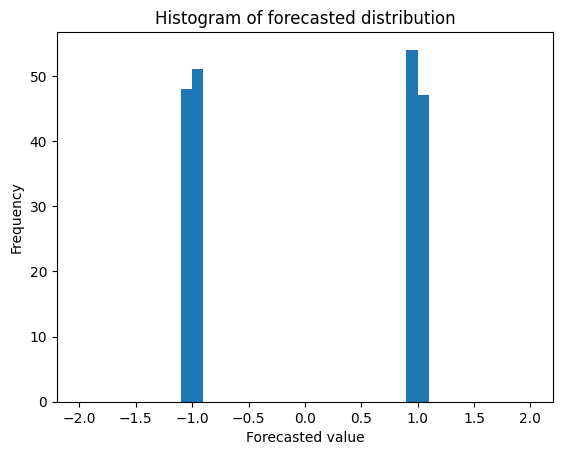

In [12]:
import matplotlib.pyplot as plt

#x = list(forecasts[0].samples.flatten())
x = np.array([f.samples.flatten() for f in forecasts]).flatten()
plt.hist(x, bins=40,range=[-2,2])
plt.xlabel("Forecasted value")
plt.ylabel("Frequency")
plt.title("Histogram of forecasted distribution")
plt.show()

In [25]:
import pandas as pd
import numpy as np

data = pd.read_excel('../datasets/rain.xlsx', index_col=2) 

bergen = data[data["Navn"]=="Bergen - Florida Uib"]
oslo = data[data["Navn"]=="Oslo - Blindern"]

rain = list(bergen.iloc[:,2])

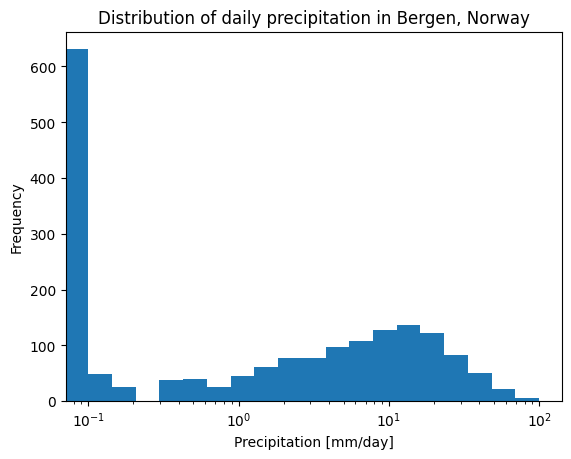

In [26]:
import matplotlib.pyplot as plt
import time
from IPython.display import clear_output

logbins = np.logspace(-1,2,20)
x = [0] + list(logbins)

# for k in range(len(x)-1):
#     plt.hist([rain[i] for i in range(1,len(rain)) if x[k] <= rain[i-1] <= x[k+1]], bins = [0] + list(logbins))
#     #plt.hist(rain, bins = [0] + list(logbins))
#     plt.xscale('log')
#     plt.show()
#     time.sleep(1)
#     clear_output(wait=True)


plt.hist(rain, bins = [0] + list(logbins))
plt.xscale('log')
plt.xlabel("Precipitation [mm/day]")
plt.ylabel("Frequency")
plt.title("Distribution of daily precipitation in Bergen, Norway")
plt.show()

In [27]:
k = pd.concat([bergen.rename(columns={"Nedbør (døgn)":"bergen"}).iloc[:,2], oslo.rename(columns={"Nedbør (døgn)":"oslo"}).iloc[:,2]], axis = 1).dropna()
k.index = pd.to_datetime(k.index, dayfirst=True)
k = k.sort_index()

data_array = np.array([k["bergen"],k["oslo"]])

In [28]:
# Create training and test datasets
dataset_train = ListDataset(
    [
        {
            "target": data_array[:,:1000],
            "start": k.index[0],
        }
    ],
    freq="D",
    one_dim_target=False
)

# Create training and test datasets
dataset_test = ListDataset(
    [
        {
            "target": data_array[:,1200:],
            "start": k.index[1200],
        }
    ],
    freq="D",
    one_dim_target=False
)

In [29]:
# Train timegrad on training dataset
estimator = TimeGradEstimator(
    target_dim=2,
    prediction_length=1,
    context_length=1,
    cell_type='GRU',
    input_size=10,
    freq="1D",
    loss_type='l2',
    scaling=False,
    diff_steps=100,
    beta_end=0.1,
    beta_schedule="linear",
    trainer=Trainer(device=device,
                    epochs=20,
                    learning_rate=1e-3,
                    num_batches_per_epoch=100,
                    batch_size=64,)
)

In [30]:
predictor = estimator.train(dataset_train, num_workers=4)

  0%|          | 0/99 [00:00<?, ?it/s]/Users/edvard/Documents/Imperial College/Year 4/Final Year Project/Final-Year-Project/timegrad/.venv/lib/python3.8/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/Users/edvard/Documents/Imperial College/Year 4/Final Year Project/Final-Year-Project/timegrad/.venv/lib/python3.8/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/Users/edvard/Documents/Imperial College/Year 4/Final Year Project/Final-Year-Project/timegrad/.venv/lib/python3.8/site-packages/gluonts/dataset/common.py:329: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  timestamp.floor(timestamp.freq), timestamp.freq
/Users/edvard/Documents/Imperial College/Year 4/Final Year Projec

In [31]:
predictions = predictor.predict(dataset=dataset_test,num_samples=1000)

In [ ]:
for m in predictions:
    print(m)
    break

In [32]:
prediction_list = list(predictions)

In [48]:
dataset_test.list_data[0]["target"]

array([[ 0. ,  0.5,  0.4, ...,  9.7, 17.5, 20.6],
       [ 3.1,  5.9,  0.6, ...,  4.6,  7.7,  0.8]])

In [34]:
logbins

array([  0.1       ,   0.14384499,   0.20691381,   0.29763514,
         0.42813324,   0.61584821,   0.88586679,   1.27427499,
         1.83298071,   2.6366509 ,   3.79269019,   5.45559478,
         7.8475997 ,  11.28837892,  16.23776739,  23.35721469,
        33.59818286,  48.32930239,  69.51927962, 100.        ])

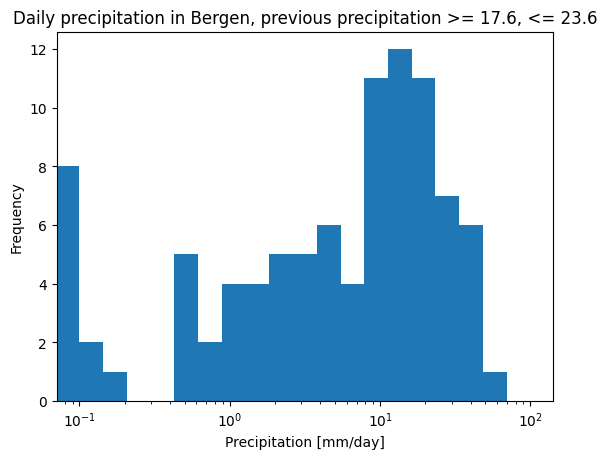

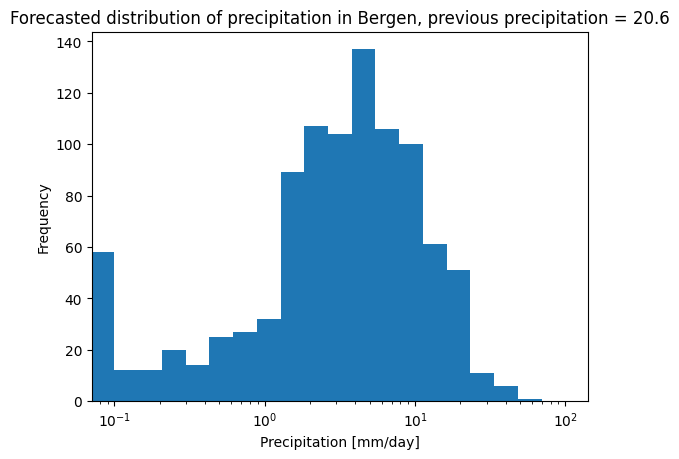

In [40]:
import matplotlib.pyplot as plt
import time
from IPython.display import clear_output

logbins = np.logspace(-1,2,20)
x = [0] + list(logbins)

for i in range(len(x) - 1):
    if x[i] <= 20.6 <= x[i+1]:
        bin_num = i
        break

#plt.hist([rain[i] for i in range(1,len(rain)) if x[bin_num] <= rain[i-1] <= x[bin_num+1]], bins = [0] + list(logbins))
plt.hist([rain[i] for i in range(1,len(rain)) if 17.6 <= rain[i-1] <= 23.6], bins = [0] + list(logbins))
plt.xscale('log')
plt.xlabel("Precipitation [mm/day]")
plt.ylabel("Frequency")
plt.title("Daily precipitation in Bergen, previous precipitation >= 17.6, <= 23.6")
plt.show()

plt.hist(prediction_list[0].samples[:,:,0].flatten(), bins = [0] + list(logbins))
plt.xscale('log')
plt.xlabel("Precipitation [mm/day]")
plt.ylabel("Frequency")
plt.title("Forecasted distribution of precipitation in Bergen, previous precipitation = 20.6")
plt.show()

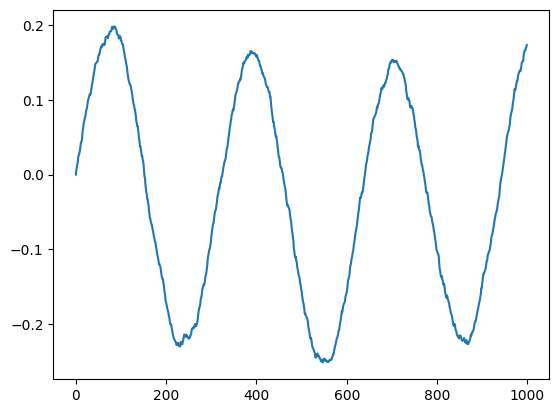

In [59]:
import matplotlib.pyplot as plt
import numpy as np
import math


z = []
y = []

for i in range(1000):
    y.append(np.sin(0.02*i))
    if z:
        z.append(np.random.normal(z[i-1],0.01))
    else:
        z.append(0)


x = np.array(z) + np.array(y)


plt.plot(x)